In [52]:
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General imports
import time
import math
import json
import requests
import functools as ft
import scipy.stats as stats

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# XGBoost and machine learning
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, PrecisionRecallDisplay, make_scorer
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA

# Hyperparameter tuning with Skopt
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [53]:
all_seasons = []

for season in range(2021, 2024):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023
Successfully fetched data for season 2023-2024
      playerId     skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0      8465009        Zdeno Chara            D           72       12        0   
1      8466138       Joe Thornton            C           34        5        0   
2      8469455       Jason Spezza            C           71       13        0   
3      8470281       Duncan Keith            D           64       20        0   
4      8470595         Eric Staal            C           72       15        0   
...        ...                ...          ...          ...      ...      ...   
1250   8484314       Jiri Smejkal            L           20        1        0   
1251   8484321  Nikolas Matinpalo            D            4        0        0   
1252   8484325    Waltteri Merela            C           19        0        0   
1253   8484326        Patrik Koch            D   

In [54]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 60)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df.rename(columns={'timeOnIcePerGame': 'time_on_ice_per_game'}, inplace=True)
nhl_api_df['regulation_game_winning'] = nhl_api_df['game_winning_goals'] - nhl_api_df['ot_goals']

In [55]:
goals_up_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [56]:
urls = {
    "goals_up_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_up_by_one'),
    "goals_down_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_down_by_one'),
    "tied": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_when_tied'),
    "total": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

In [57]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts', 'iCF', 'Rebounds Created']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 60]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)

In [58]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [59]:
merged_natural_stat

,Player,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,Rush Attempts,iCF,Rebounds Created
1,Jason Spezza,71,2,4,1,12,97,9.20,131,83,33,8,175,13
2,Eric Staal,72,3,2,3,14,106,12.99,142,119,65,8,183,17
3,Jeff Carter,227,12,10,9,43,429,48.99,563,412,221,33,730,81
4,Dustin Brown,64,1,2,2,9,146,15.64,196,129,65,6,238,12
5,Zach Parise,194,3,6,12,41,370,50.43,472,406,239,22,556,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,Juraj Slafkovsky,121,2,5,6,24,194,25.41,287,243,113,7,406,36
764,Ben Meyers,67,0,1,2,6,54,7.86,81,69,44,4,107,6
769,Andrei Kuzmenko,153,8,13,18,61,264,41.21,407,391,216,9,541,61
772,Connor Bedard,68,2,6,9,22,206,23.82,299,226,69,17,401,34


In [60]:
nhl_api_df

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,time_on_ice_per_game,regulation_game_winning
0,8469455,Jason Spezza,C,71,13,0,1,644.760500,1
1,8470595,Eric Staal,C,72,15,0,1,854.222200,1
2,8470604,Jeff Carter,C,227,46,2,8,878.955267,6
3,8470606,Dustin Brown,R,64,19,0,0,884.343700,0
4,8470610,Zach Parise,L,194,38,1,7,887.950067,6
...,...,...,...,...,...,...,...,...,...
508,8483515,Juraj Slafkovsky,L,121,36,0,2,904.534650,2
509,8483570,Ben Meyers,C,67,2,0,0,593.053333,0
510,8483808,Andrei Kuzmenko,L,153,59,3,8,933.780800,5
511,8484144,Connor Bedard,C,68,39,1,2,1187.000000,1


In [61]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [62]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,time_on_ice_per_game,regulation_game_winning,GP,...,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,Rush Attempts,iCF,Rebounds Created
0,8469455,Jason Spezza,C,71,13,0,1,644.760500,1,71,...,1,12,97,9.20,131,83,33,8,175,13
1,8470595,Eric Staal,C,72,15,0,1,854.222200,1,72,...,3,14,106,12.99,142,119,65,8,183,17
2,8470604,Jeff Carter,C,227,46,2,8,878.955267,6,227,...,9,43,429,48.99,563,412,221,33,730,81
3,8470606,Dustin Brown,R,64,19,0,0,884.343700,0,64,...,2,9,146,15.64,196,129,65,6,238,12
4,8470610,Zach Parise,L,194,38,1,7,887.950067,6,194,...,12,41,370,50.43,472,406,239,22,556,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,8483515,Juraj Slafkovsky,L,121,36,0,2,904.534650,2,121,...,6,24,194,25.41,287,243,113,7,406,36
509,8483570,Ben Meyers,C,67,2,0,0,593.053333,0,67,...,2,6,54,7.86,81,69,44,4,107,6
510,8483808,Andrei Kuzmenko,L,153,59,3,8,933.780800,5,153,...,18,61,264,41.21,407,391,216,9,541,61
511,8484144,Connor Bedard,C,68,39,1,2,1187.000000,1,68,...,9,22,206,23.82,299,226,69,17,401,34


In [63]:
null_rows = merged_clutch_goals[merged_clutch_goals.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, assists, ot_goals, game_winning_goals, time_on_ice_per_game, regulation_game_winning, GP, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, Rush Attempts, iCF, Rebounds Created]
Index: []

[0 rows x 22 columns]


In [64]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)

In [65]:
columns = ['ot_goals', 'regulation_game_winning', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'Rebounds Created']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


In [66]:
merged_clutch_goals['clutch_score'] = 0.3 * merged_clutch_goals['goals_when_tied_per_game'] + 0.3 * merged_clutch_goals['goals_down_by_one_per_game'] + 0.2 * merged_clutch_goals['goals_up_by_one_per_game'] + 0.1 * merged_clutch_goals['regulation_game_winning_per_game'] + 0.1 * merged_clutch_goals['ot_goals_per_game']

In [67]:
merged_clutch_goals['clutch_score'] *= 100
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
318,Auston Matthews,15.26,1.0
236,David Pastrnak,14.32,2.0
222,Leon Draisaitl,12.86,3.0
304,Kirill Kaprizov,12.56,4.0
267,Connor McDavid,12.35,5.0
152,Filip Forsberg,11.49,6.0
264,Kyle Connor,11.15,7.0
201,Nathan MacKinnon,11.10,8.0
274,Sebastian Aho,10.99,9.0
453,Jack Hughes,10.79,10.0


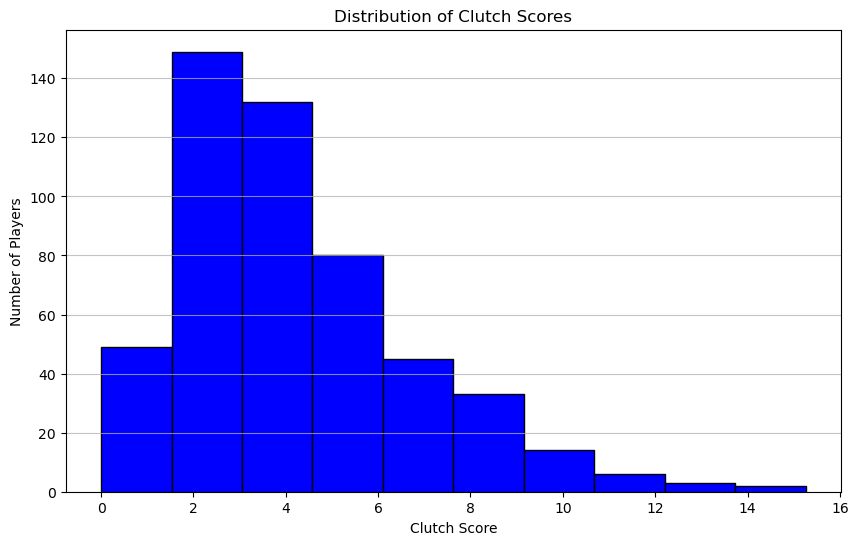

In [68]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Clutch Score")
plt.ylabel("Number of Players")
plt.title("Distribution of Clutch Scores")
plt.show()

In [69]:
threshold_elite = merged_clutch_goals['clutch_score'].quantile(0.85)
threshold_high = merged_clutch_goals['clutch_score'].quantile(0.7)
threshold_average = merged_clutch_goals['clutch_score'].quantile(0.5)


def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold_elite:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

In [70]:
merged_clutch_goals['clutch_label'].value_counts()

clutch_label
0    436
1     77
Name: count, dtype: int64

In [71]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game','time_on_ice_per_game']
y_var = 'clutch_label'

X = merged_clutch_goals[x_var]
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [72]:
skf = StratifiedKFold(n_splits=10)

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

scores = cross_validate(xgb_model, X, y, cv = skf, scoring = scoring)

df_scores = pd.DataFrame.from_dict(scores)

df_scores.mean()

fit_time          0.250878
score_time        0.016971
test_accuracy     0.903054
test_precision    0.857000
test_recall       0.667857
test_f1           0.698954
dtype: float64

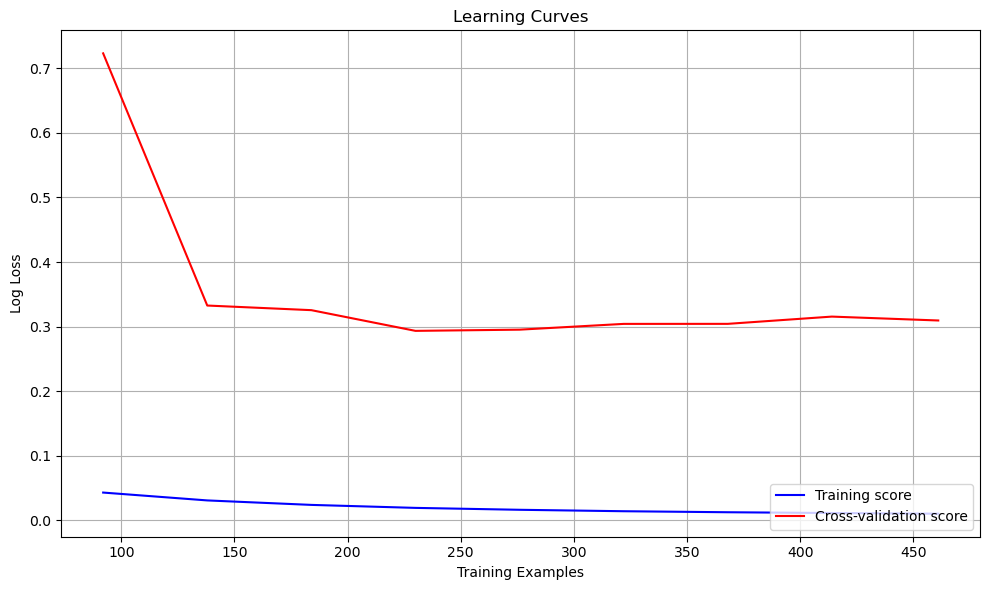

In [73]:
cv = StratifiedKFold(n_splits=10)

train_sizes = np.linspace(0.1, 1.0, 10)
    
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss',
)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

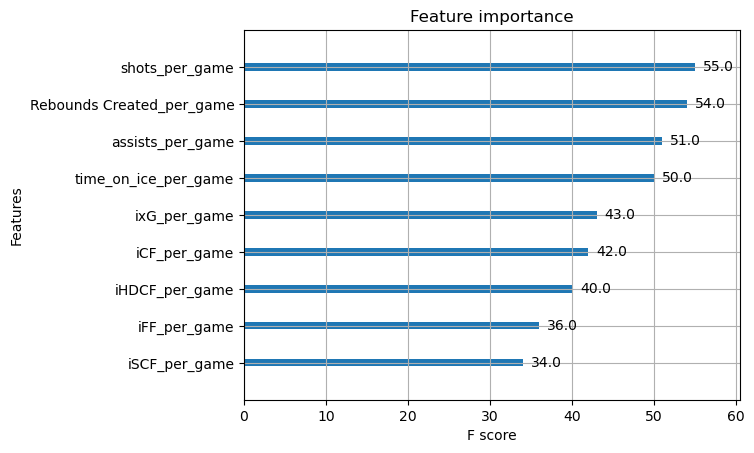

In [74]:
plot_importance(xgb_model)
plt.show()

In [75]:
x_var_adjusted = ['shots_per_game', 'ixG_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals[x_var_adjusted]

In [76]:
param_grid = {
    'max_depth': Integer(2,5),
    'min_child_weight': Integer(2,3), 
    'n_estimators': Integer(200, 300),
    'learning_rate': Real(0.03, 0.04), 
    'reg_alpha': Real(0.75, 1.9),
    'reg_lambda': Real(0.75, 1.9),
    'subsample': Real(0.7, 1), 
    'colsample_bytree': Real(0.7, 1)  
}

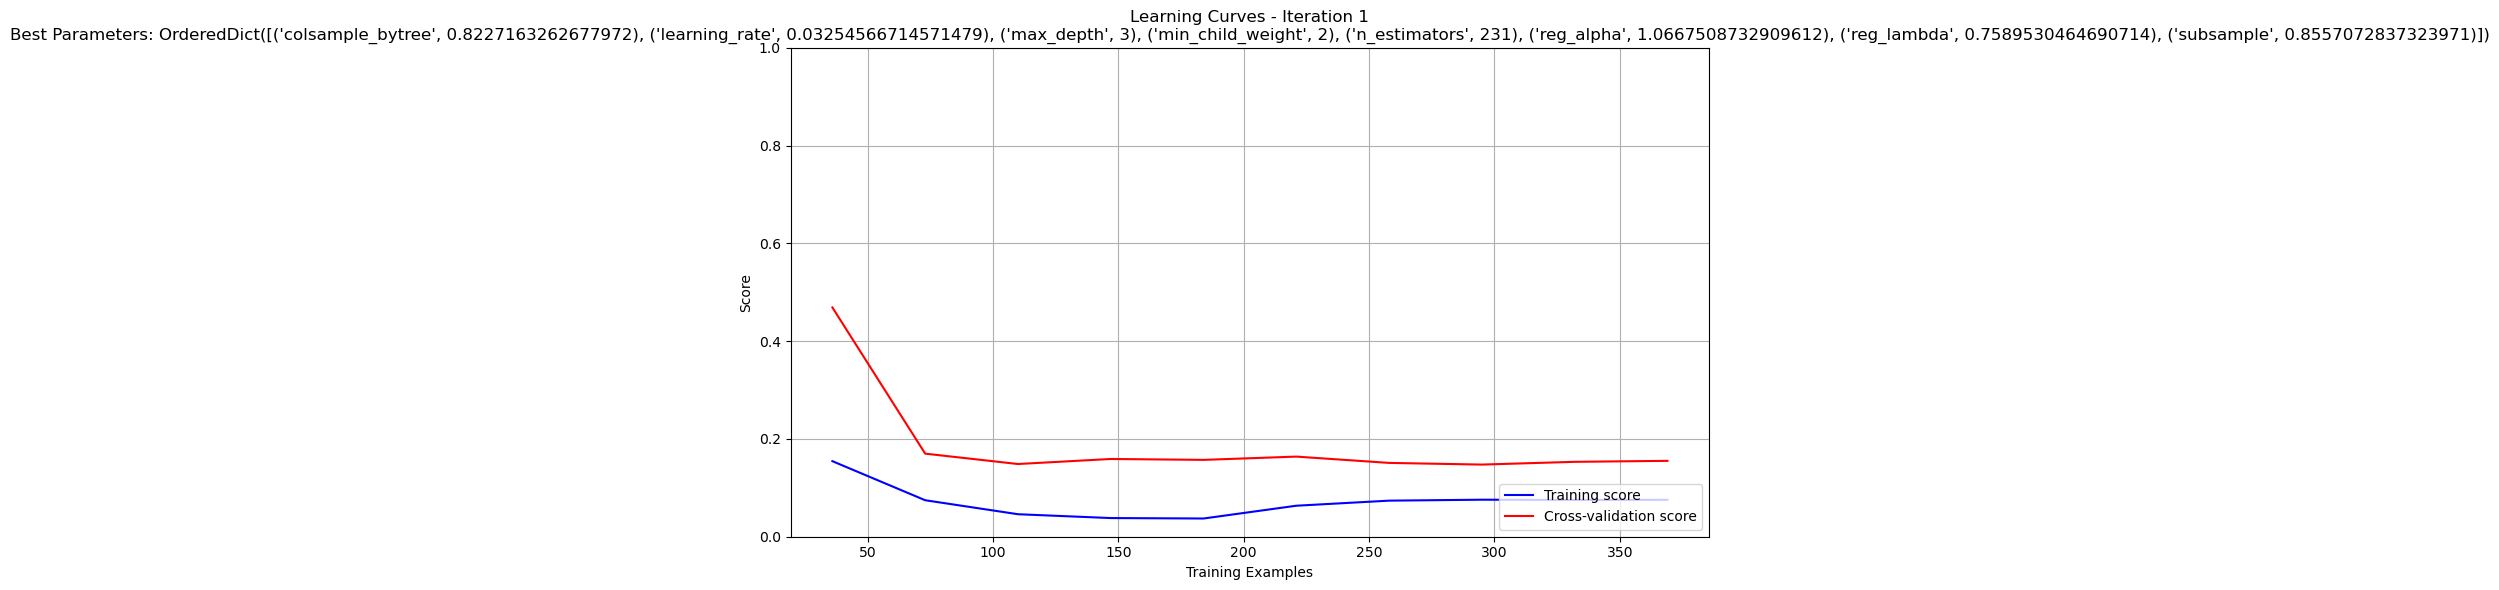

Recall Score:  0.8666666666666667


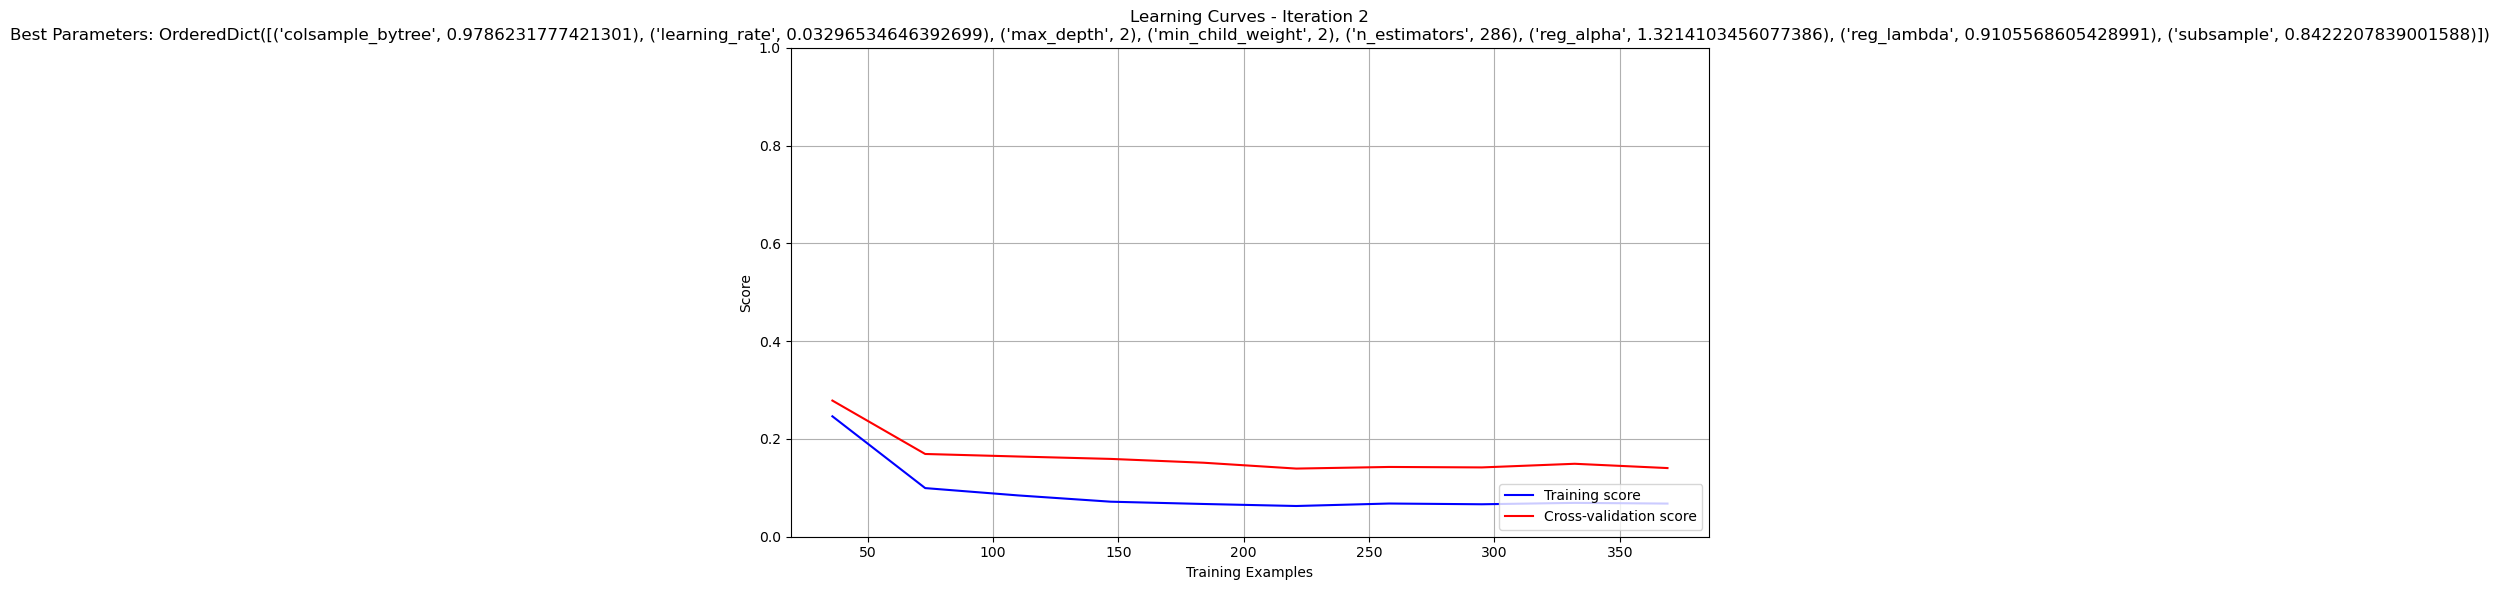

Recall Score:  0.6
Average Accuracy: 0.941747572815534
Average Precision: 0.8392857142857143
Average Recall: 0.7333333333333334
Average F1 Score: 0.7816091954022988
Averaged Hyperparameters:
colsample_bytree      0.900670
learning_rate         0.032756
max_depth             2.500000
min_child_weight      2.000000
n_estimators        258.500000
reg_alpha             1.194081
reg_lambda            0.834755
subsample             0.848964
dtype: float64


In [77]:
cv = StratifiedKFold(n_splits=10)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
best_hyperparams_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


for _ in range(2):
    rs = np.random.randint(1, 1000)

    train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state = rs
    )

    class_weights = compute_sample_weight(class_weight='balanced', y=train_y)
    
    xgb_model_adjusted = xgb.XGBClassifier(n_estimators = 100, eval_metric = 'logloss')
    xgb_model_adjusted.fit(train_x, train_y, sample_weight = class_weights)

    random_search = BayesSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, scoring= ['recall'], refit='recall', n_jobs = -1)

    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_
    
    title = f'Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, train_x, train_y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  

    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, zero_division=0)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)

    print("Recall Score: ", recall)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    best_hyperparams_list.append(random_search.best_params_)

print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.median(recall_list))
print("Average F1 Score:", np.mean(f1_list))

hyperparams_df = pd.DataFrame(best_hyperparams_list)
averaged_hyperparams = hyperparams_df.mean()
print("Averaged Hyperparameters:")
print(averaged_hyperparams)

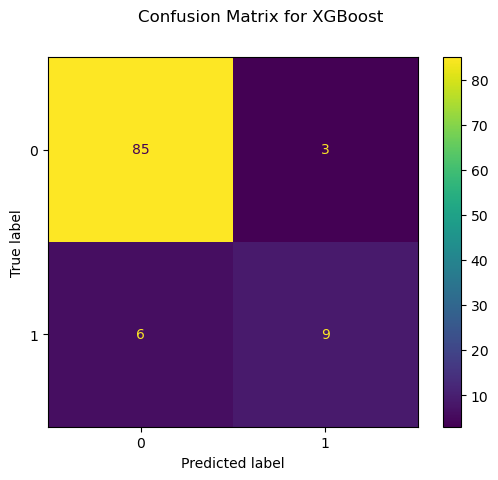

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(test_y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [79]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X= merged_clutch_goals[x_var]
y_var = 'clutch_score'  
y = merged_clutch_goals[y_var]

correlation = X.corrwith(y) 
print(correlation)

shots_per_game               0.882575
ixG_per_game                 0.881696
iFF_per_game                 0.887190
iSCF_per_game                0.899963
iHDCF_per_game               0.723577
assists_per_game             0.767368
iCF_per_game                 0.879511
Rebounds Created_per_game    0.794778
time_on_ice_per_game         0.786481
dtype: float64


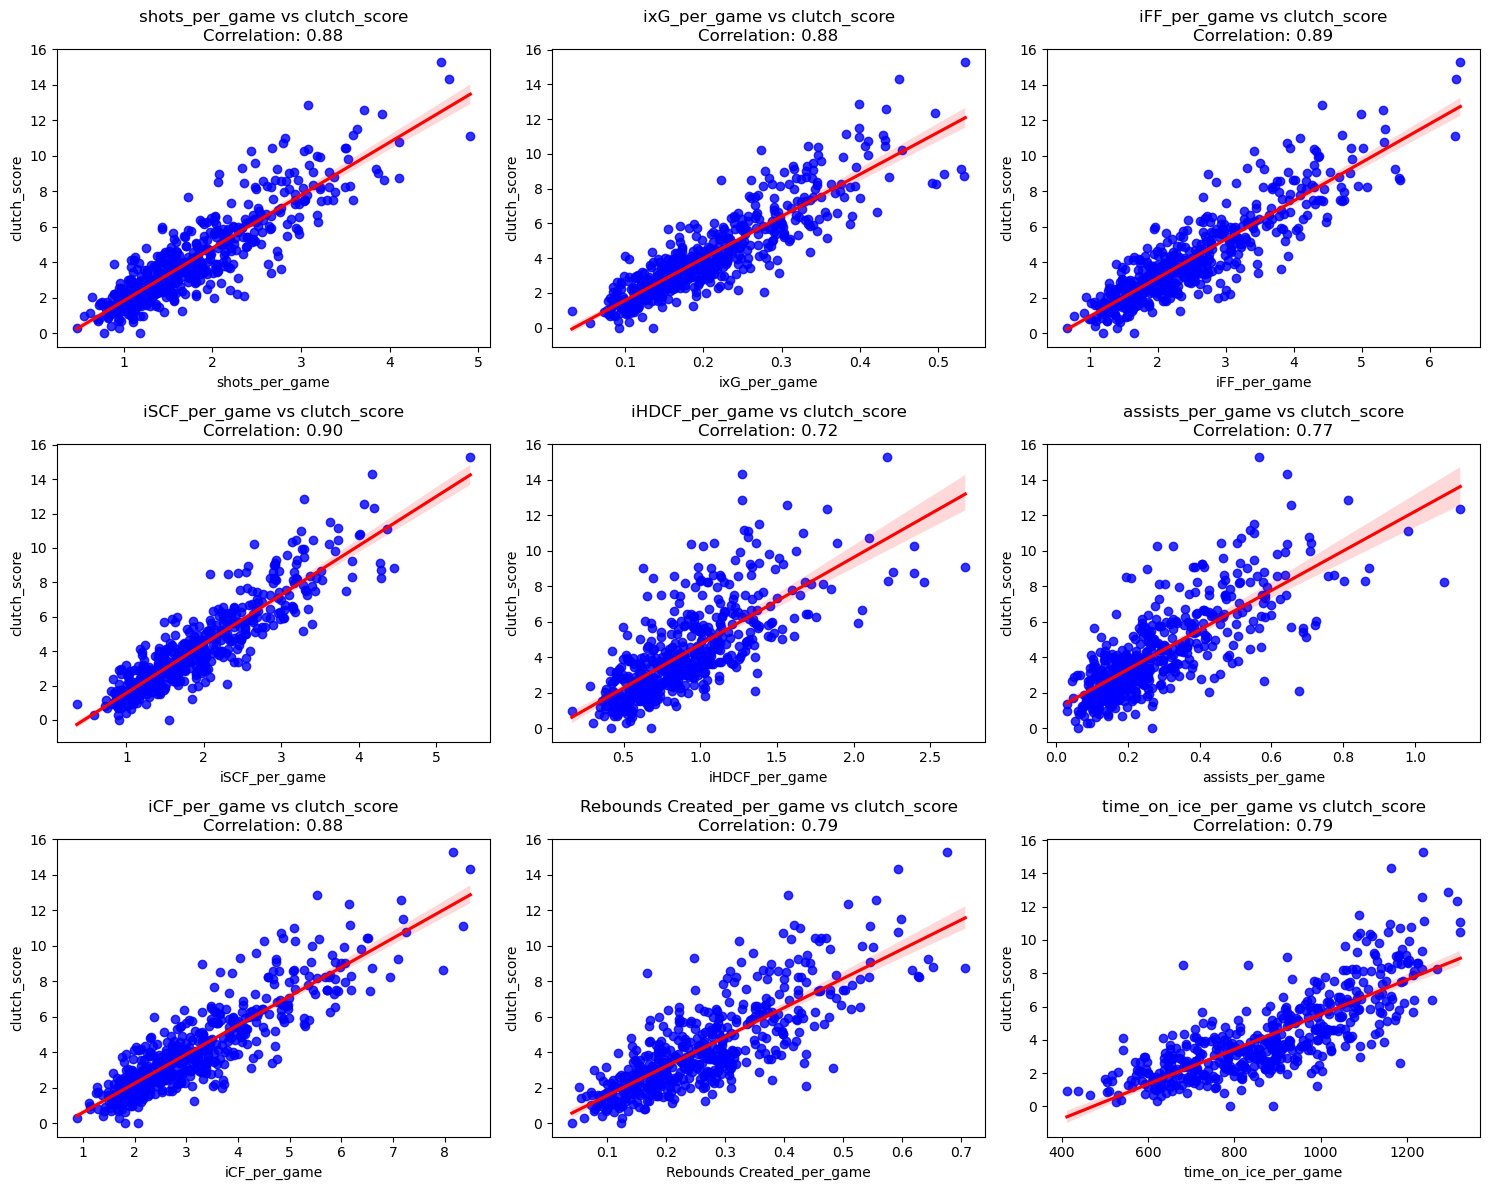

In [80]:
plt.figure(figsize=(15, 12))  

for i, var in enumerate(x_var):
    plt.subplot(3, 3, i+1)
    
    sns.regplot(data=merged_clutch_goals, x=var, y=y, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    
    plt.title(f'{var} vs {y_var}\nCorrelation: {correlation[var]:.2f}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel(y_var)

plt.tight_layout()  
plt.show()

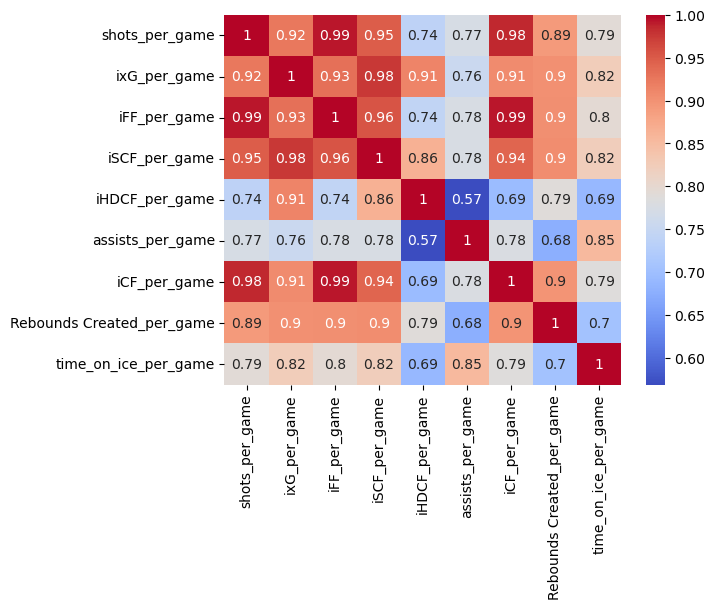

In [81]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

In [82]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'Rebounds Created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals[y_var]

X_scaled = StandardScaler().fit_transform(X_adjusted)

train_x, test_x, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

alphas_random = np.random.uniform(0.0001, 1000, 50)

ridge_cv = RidgeCV(alphas=alphas_random, store_cv_values=True)
ridge_cv.fit(train_x, train_y)

y_pred = ridge_cv.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))

MSE:  1.287417680812485
RMSE:  1.134644297043124
MAE:  0.5729250864582065
R²:  0.8326814602209589
Adjusted R²:  0.8289167930759305


In [83]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, validation_scores = learning_curve(
ridge_cv,
X_scaled,
y, train_sizes = train_sizes, cv = 10,
scoring = 'neg_mean_squared_error')


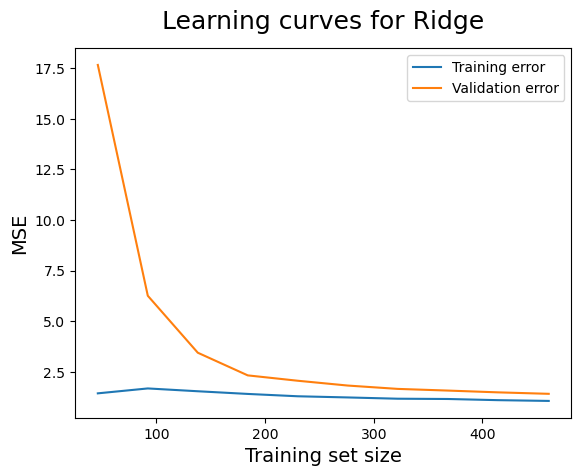

In [84]:
import matplotlib.pyplot as plt

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Ridge', fontsize = 18, y = 1.03)
plt.legend()

In [85]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(60))

All predictions and actual values:
                   Player  Actual  Predicted     Error
460       Pavel Dorofeyev    8.51   4.525132  3.984868
222        Leon Draisaitl   12.86   8.987199  3.872801
379       Gabriel Vilardi    8.96   5.169292  3.790708
318       Auston Matthews   15.26  12.307862  2.952138
131        Mark Scheifele    9.32   7.024018  2.295982
245         Brayden Point   10.74   8.473704  2.266296
358          Trevor Moore    4.37   6.488615  2.118615
486       Alexander Holtz    4.36   2.551999  1.808001
385       Jason Robertson    9.92   8.183671  1.736329
87       Evgeny Kuznetsov    3.77   5.498112  1.728112
13      Alexander Radulov    1.83   3.544568  1.714568
258       Victor Olofsson    5.71   4.021249  1.688751
476       Jake Neighbours    5.12   3.510195  1.609805
166         Josh Anderson    3.98   5.458884  1.478884
127   Ryan Nugent-Hopkins    5.42   6.897945  1.477945
341           Noah Gregor    2.84   4.285410  1.445410
512           Zach Benson    2

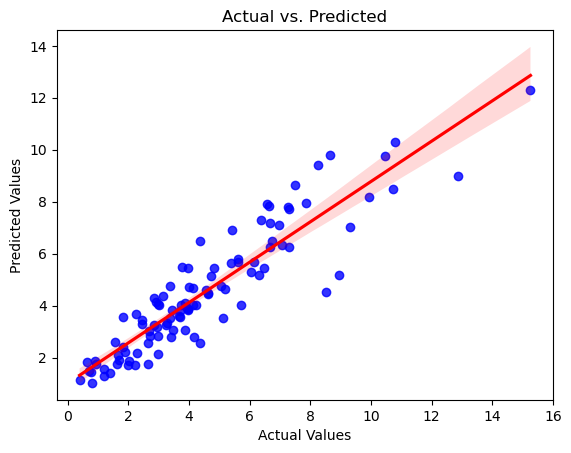

In [86]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

<Axes: xlabel='clutch_score'>

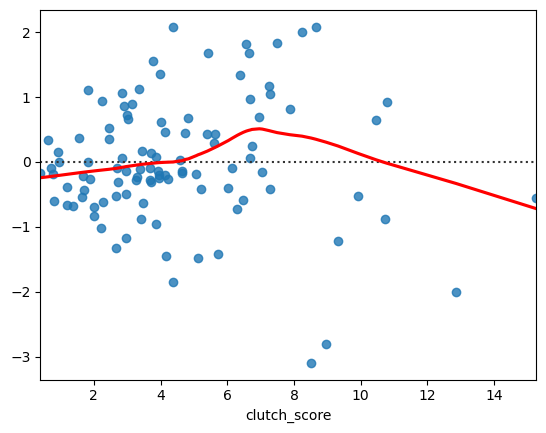

In [87]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))

There are 50 influential points.
Outliers based on Cook's Distance:
                  Player  Actual  Predicted  Cook's Distance
318      Auston Matthews   15.26  13.021989         0.057776
236       David Pastrnak   14.32  11.635689         0.043192
222       Leon Draisaitl   12.86   9.601531         0.057349
304      Kirill Kaprizov   12.56  10.464729         0.012430
152       Filip Forsberg   11.49   9.094171         0.026672
201     Nathan MacKinnon   11.10  12.100523         0.010687
274        Sebastian Aho   10.99   8.205665         0.016469
245        Brayden Point   10.74   8.957700         0.020589
221         Sam Reinhart   10.45   8.380298         0.015439
346        Tage Thompson   10.44   8.141979         0.013541
50        Steven Stamkos   10.37   8.977198         0.008339
72         Chris Kreider   10.25   7.850095         0.042746
390          Josh Norris   10.24   6.418795         0.025789
385      Jason Robertson    9.92   8.077267         0.012333
131       Mark Sc

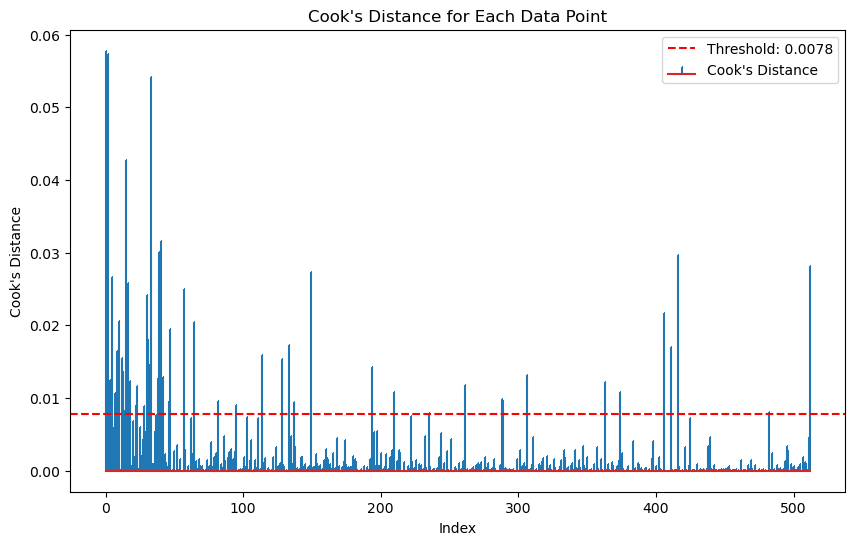

In [112]:
X_with_intercept = sm.add_constant(X_scaled)

ols_model = sm.OLS(y, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()


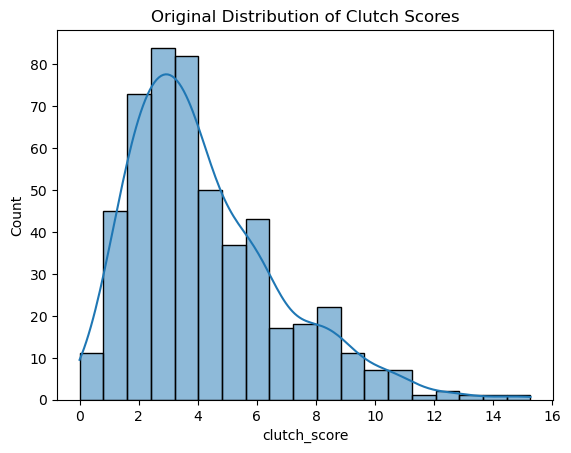

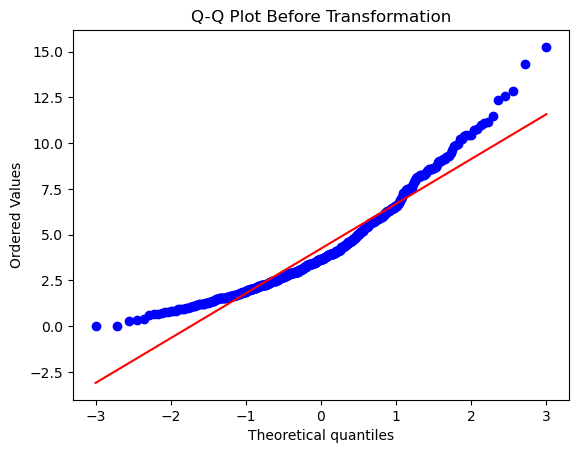

In [89]:
sns.histplot(y, kde=True)
plt.title("Original Distribution of Clutch Scores")
plt.show()

stats.probplot(y, dist="norm", plot=plt)
plt.title("Q-Q Plot Before Transformation")
plt.show()

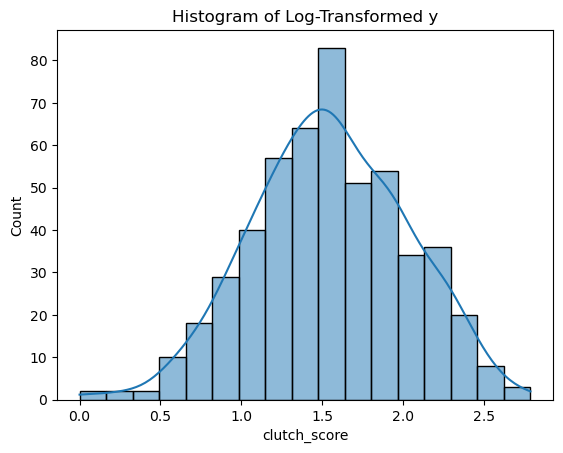

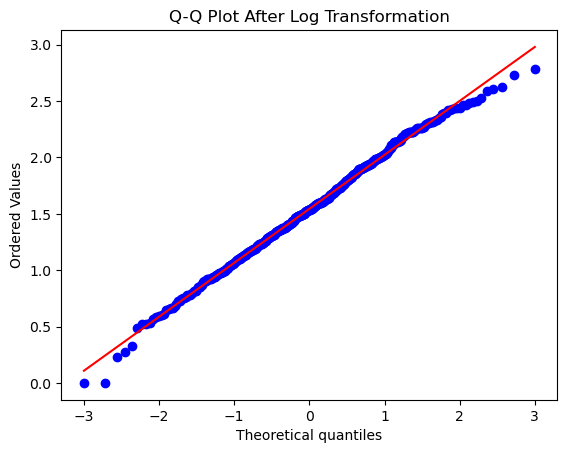

In [90]:
y_log = np.log(y + 1)  

sns.histplot(y_log, kde=True)
plt.title("Histogram of Log-Transformed y")
plt.show()

stats.probplot(y_log, dist="norm", plot=plt)
plt.title("Q-Q Plot After Log Transformation")
plt.show()

In [95]:
epsilon = np.abs(X_scaled.min()) + 1

X_shifted = X_scaled + epsilon

In [96]:
y_log = np.log(y + 1)

X_log = np.log(X_shifted)

train_x, test_x, train_y, test_y = train_test_split(
    X_log, 
    y_log, 
    test_size=0.2, 
    random_state=42
)

alphas_random = np.random.uniform(0.0001, 1000, 50)
ridge_cv = RidgeCV(alphas=alphas_random, store_cv_values=True)
ridge_cv.fit(train_x, train_y)
y_pred = ridge_cv.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))


MSE:  0.04316997670678528
RMSE:  0.2077738595367215
MAE:  0.12215961626163896
R²:  0.8307644666555213
Adjusted R²:  0.8269566671552705


In [97]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(55))

All predictions and actual values:
                   Player    Actual  Predicted     Error
460       Pavel Dorofeyev  2.252344   1.677493  0.574851
374       Jonas Rondbjerg  0.488580   1.042056  0.553476
367       Jake Leschyshyn  0.329304   0.841799  0.512495
379       Gabriel Vilardi  2.298577   1.806802  0.491776
13      Alexander Radulov  1.040277   1.476783  0.436507
486       Alexander Holtz  1.678964   1.250785  0.428179
406          Parker Kelly  0.647103   1.059777  0.412674
96          Riley Sheahan  0.530628   0.936078  0.405449
258       Victor Olofsson  1.903599   1.526044  0.377555
476       Jake Neighbours  1.811562   1.449988  0.361575
78    Nicolas Deslauriers  0.570980   0.921087  0.350108
222        Leon Draisaitl  2.629007   2.292178  0.336829
31        Derick Brassard  1.642873   1.310115  0.332758
180           John Hayden  0.662688   0.988603  0.325915
358          Trevor Moore  1.680828   1.994829  0.314001
252           Max Willman  1.294727   0.980928  0.313

There are 17 influential points.
Outliers based on Cook's Distance:
               Player    Actual  Predicted  Cook's Distance
460   Pavel Dorofeyev  2.252344   1.728610         0.013745
228       Jakub Vrana  2.248129   1.782178         0.020592
472       Connor Zary  1.927164   1.367080         0.021831
355   Michael Carcone  1.897620   1.279476         0.022405
498      Walker Duehr  1.633154   0.998908         0.028097
459   Simon Holmstrom  1.593309   1.074611         0.014688
363        Mason Shaw  1.302913   0.942853         0.015494
3        Dustin Brown  1.160021   1.685418         0.017319
47      Jakub Voracek  1.134623   1.466305         0.013346
22   Patric Hornqvist  1.121678   1.729983         0.039643
168      Connor Brown  0.797507   1.524247         0.014994
171  Kurtis MacDermid  0.667829   0.325126         0.022378
180       John Hayden  0.662688   1.081184         0.014774
367   Jake Leschyshyn  0.329304   0.856290         0.016349
177   Saku Maenalanen  0.270027 

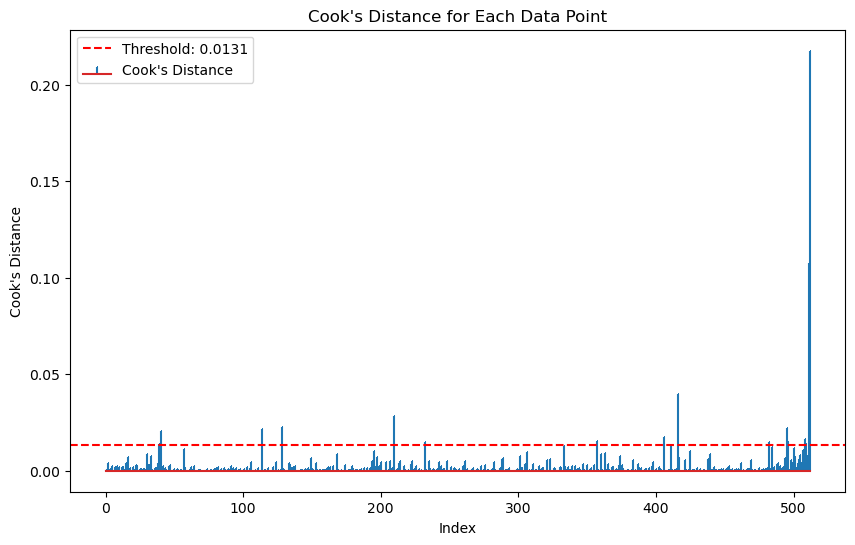

In [113]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / (316-9-1)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(cooks_d, markerfmt=",", label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

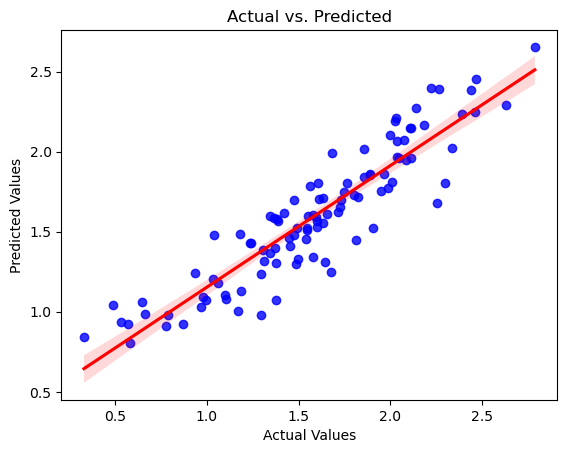

In [115]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

<Axes: xlabel='clutch_score'>

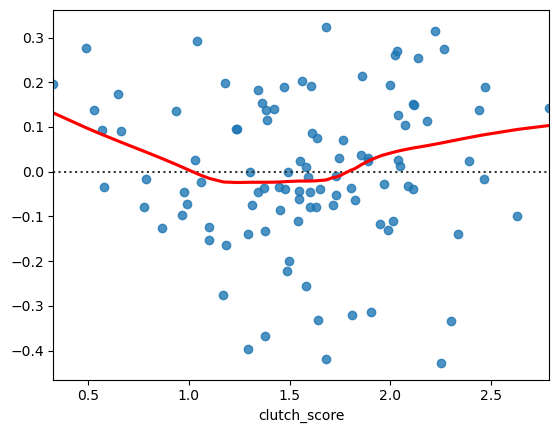

In [116]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))